# Generates experimental figure in the paper

## This script assumes you have trained imagenet using `imagenet_train_crossval.py` for the conditions stored in the paper and then saved them in folders resnetX/model_name/model.pickle which we load and compute a forward pass to get the test accuracy.

In [6]:
# These imports enhance Python2/3 compatibility.
from __future__ import print_function, absolute_import, division, unicode_literals, with_statement

# Set-up imports and directories

In [73]:
import cleanlab
import numpy as np
import torch
import sys

# For visualizing images of label errors
from PIL import Image

# PyTorch stuff
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# Standard imports
import os
import numpy as np
from matplotlib import pyplot as plt

# Needed for computing the Clopper-Pearson exact confidence limits
from statsmodels.stats.proportion import proportion_confint

# urllib2 for python2 and python3
try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen  

# For plotting
import seaborn
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
    
# Where imagenet dataset is located
val_dir = '/datasets/datasets/imagenet/val/'
train_dir = '/datasets/datasets/imagenet/train/'

In [8]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def parse_line(i):
    '''parses torch training logs for accuracies'''
    stuff = i[3:-1].split(" ")
    return (stuff[1], stuff[3])


def validate(val_loader, model, gpu):
    '''Computes validation accuracy for each class for a PyTorch model.'''
    
    # switch to evaluate mode
    model.eval()
    acc1s, acc5s = [], []
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # Check that labels are all label i.
            assert(all(target.numpy() == i))
            print('\rProgress: {:.2%}'.format(i / 1000), end='')
            
            input = input.cuda(gpu, non_blocking=True)
            target = target.cuda(gpu, non_blocking=True)

            # compute output
            output = model(input)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            acc1s.append(acc1)
            acc5s.append(acc5)
    
    # Move from GPU to CPU
    acc1s = [z.cpu().numpy()[0] for z in acc1s]
    acc5s = [z.cpu().numpy()[0] for z in acc5s]

    return acc1s, acc5s

In [9]:
# Choose a GPU to use.
gpu = 0

In [10]:
# Get train set size
train_dataset = datasets.ImageFolder(train_dir)
imagenet_train_size = len(train_dataset.imgs)
del train_dataset

In [81]:
# Set-up validation data
val_dataset = datasets.ImageFolder(
    val_dir, 
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
)
imagenet_val_size = len(val_dataset.imgs)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=50, shuffle=False,
    num_workers=10, pin_memory=True,
)

In [12]:
# Set-up name mapping for ImageNet train data
url = 'https://gist.githubusercontent.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57/'
url += 'raw/aa66dd9dbf6b56649fa3fab83659b2acbf3cbfd1/map_clsloc.txt'
with urlopen(url) as f:
    lines = [x.decode('utf-8') for x in f.readlines()]    
    nid2name = dict([(l.split(" ")[0], l.split(" ")[2][:-1]) for l in lines])
    
nid2idx = val_dataset.class_to_idx
idx2nid = {v: k for k, v in nid2idx.items()}
name2nid = {v: k for k, v in nid2name.items()}
idx2name = {k: nid2name[v] for k, v in idx2nid.items()}

In [13]:
# Fetch label errors identified with confident learning
label_error_mask = ~np.load("/home/cgn/masks/imagenet_train_bool_mask.npy")
num_label_errors = sum(np.array(label_error_mask, dtype=int))

# First we need to use confident learning to compute the confident joint

In [14]:
# Stores cross validated predicted probabilities for imagenet train set
pyx_file = 'imagenet__train__model_resnet50__pyx.npy' # trained from scratch with 10fold cv

# Stored results directory
pyx_dir = '/datasets/cgn/pyx/imagenet/'

# Load in data
pyx = np.load(pyx_dir + pyx_file)
imgs, labels = [list(z) for  z in zip(*datasets.ImageFolder(train_dir).imgs)]
labels = np.array(labels, dtype=int)

In [15]:
# Compute the confident joint
# Parallelized across all cores of your CPU. On a 20-core CPU, takes 30 seconds.
cj = cleanlab.latent_estimation.compute_confident_joint(labels, pyx)

In [16]:
# Compute an estimate of the true joint
# This won't affect results much, but you may use it instead of confident joint
joint = cleanlab.latent_estimation.estimate_joint(labels, pyx, confident_joint=cj)
joint_non_diag = joint - np.eye(len(joint)) * joint.diagonal()

In [17]:
# Compute a list of the (row,column) indices with largest non-digonal value (most noise)
cj_non_diag = cj - np.eye(len(cj)) * cj.diagonal()
largest_non_diag_raveled = np.argsort(cj_non_diag.ravel())[::-1]
largest_non_diag = np.unravel_index(largest_non_diag_raveled, cj_non_diag.shape)
largest_non_diag = list(zip(*(list(z) for z in largest_non_diag)))

In [18]:
# Let's view some things
idx = joint.diagonal().argmin()
print("Least confident class by diagonal of joint:", nid2name[idx2nid[idx]], idx)
idx = cj_non_diag.sum(axis = 0).argmax()
print("Least confident class by max sum of row of non-diagonal elements of cj:", nid2name[idx2nid[idx]], idx)
idx = joint_non_diag.sum(axis = 1).argmax()
print("Least confident class by max sum of column of non-diagonal elements of cj:", nid2name[idx2nid[idx]], idx)
print('Largest non-diagonal in cj:', [(nid2name[idx2nid[z]], z) for z in largest_non_diag[0]])
print('\nThese next two we will use in figures.\n')
largest_non_diag_idx = largest_non_diag[16][1]
print('17th of 999000 (top .0017%) largest non-diagonal value in cj:', [(nid2name[idx2nid[z]], z) for z in largest_non_diag[16]])
smallest_diag_idx = cj.diagonal().argmin()
print("Least confident class by diagonal of cj:", nid2name[idx2nid[smallest_diag_idx]], smallest_diag_idx)
forty_noisiest_classes = [z[1] for z in largest_non_diag][:40]
print("\nThe estimated actual class in the forty largest non-diagonal values (most noise) in cj:\n", [ nid2name[idx2nid[z]] for z in forty_noisiest_classes])

Least confident class by diagonal of joint: English_foxhound 167
Least confident class by max sum of row of non-diagonal elements of cj: maillot 638
Least confident class by max sum of column of non-diagonal elements of cj: maillot 638
Largest non-diagonal in cj: [('projectile', 744), ('missile', 657)]

These next two we will use in figures.

17th of 999000 (top .0017%) largest non-diagonal value in cj: [('ear', 998), ('corn', 987)]
Least confident class by diagonal of cj: English_foxhound 167

The estimated actual class in the forty largest non-diagonal values (most noise) in cj:
 ['missile', 'bathtub', 'cuirass', 'American_chameleon', 'green_lizard', 'projectile', 'maillot', 'sidewinder', 'ear', 'space_bar', 'sunglasses', 'Eskimo_dog', 'tape_player', 'sunglass', 'Siberian_husky', 'partridge', 'corn', 'bighorn', 'notebook', 'wild_boar', 'black_and_gold_garden_spider', 'breastplate', 'grasshopper', 'assault_rifle', 'maillot', 'tabby', 'miniature_poodle', 'toy_poodle', 'Border_collie', 

In [15]:
# Let's view some things
idx = joint.diagonal().argmin()
print("Least confident class by diagonal of joint:", nid2name[idx2nid[idx]], idx)
idx = cj_non_diag.sum(axis = 0).argmax()
print("Least confident class by max sum of row of non-diagonal elements of cj:", nid2name[idx2nid[idx]], idx)
idx = joint_non_diag.sum(axis = 1).argmax()
print("Least confident class by max sum of column of non-diagonal elements of cj:", nid2name[idx2nid[idx]], idx)
print('Largest non-diagonal in cj:', [(nid2name[idx2nid[z]], z) for z in largest_non_diag[0]])
print('\nThese next two we will use in figures.\n')
largest_non_diag_idx = largest_non_diag[16][1]
print('17th of 999000 (top .0017%) largest non-diagonal value in cj:', [(nid2name[idx2nid[z]], z) for z in largest_non_diag[16]])
smallest_diag_idx = cj.diagonal().argmin()
print("Least confident class by diagonal of cj:", nid2name[idx2nid[smallest_diag_idx]], smallest_diag_idx)
forty_noisiest_classes = [z[1] for z in largest_non_diag][:40]
print("\nThe estimated actual class in the forty largest non-diagonal values (most noise) in cj:\n", [ nid2name[idx2nid[z]] for z in forty_noisiest_classes])

Least confident class by diagonal of joint: English_foxhound 167
Least confident class by max sum of row of non-diagonal elements of cj: maillot 638
Least confident class by max sum of column of non-diagonal elements of cj: maillot 638
Largest non-diagonal in cj: [('projectile', 744), ('missile', 657)]

These next two we will use in figures.

17th of 999000 (top .0017%) largest non-diagonal value in cj: [('ear', 998), ('corn', 987)]
Least confident class by diagonal of cj: English_foxhound 167

The estimated actual class in the forty largest non-diagonal values (most noise) in cj:
 ['missile', 'bathtub', 'cuirass', 'American_chameleon', 'green_lizard', 'projectile', 'maillot', 'sidewinder', 'ear', 'space_bar', 'sunglasses', 'Eskimo_dog', 'tape_player', 'sunglass', 'Siberian_husky', 'partridge', 'corn', 'bighorn', 'notebook', 'wild_boar', 'black_and_gold_garden_spider', 'breastplate', 'grasshopper', 'assault_rifle', 'maillot', 'tabby', 'miniature_poodle', 'toy_poodle', 'Border_collie', 

# Use the output logs during training to get the validation accuracies, for models trainined by removing 0%, 20%,..., 100% of the noisy labels identified by confident learning as well as models trained by removing a random 0%, 20%,..., 100%

In [54]:
def parse_line(i):
    '''parses torch training logs for accuracies'''
    stuff = i[3:-1].split(" ")
    return (float(stuff[1]), float(stuff[3]))

In [67]:
num_removed

{'resnet18_00': 0,
 'resnet18_100': 178294,
 'resnet18_100_argmax': 406060,
 'resnet18_100_both': 208828,
 'resnet18_100_cj_only': 140693,
 'resnet18_100_cl_pbc': 208828,
 'resnet18_100_cl_pbnr': 194125,
 'resnet18_100random': 178294,
 'resnet18_20': 35658,
 'resnet18_20_argmax': 81212,
 'resnet18_20_both': 41765,
 'resnet18_20_cj_only': 28138,
 'resnet18_20_cl_pbc': 41765,
 'resnet18_20_cl_pbnr': 38825,
 'resnet18_20random': 35658,
 'resnet18_40': 71317,
 'resnet18_40_argmax': 162424,
 'resnet18_40_both': 83531,
 'resnet18_40_cj_only': 56277,
 'resnet18_40_cl_pbc': 83531,
 'resnet18_40_cl_pbnr': 77650,
 'resnet18_40random': 71317,
 'resnet18_60': 106976,
 'resnet18_60_argmax': 243636,
 'resnet18_60_both': 125296,
 'resnet18_60_cj_only': 84415,
 'resnet18_60_cl_pbc': 125296,
 'resnet18_60_cl_pbnr': 116475,
 'resnet18_60random': 106976,
 'resnet18_80': 142635,
 'resnet18_80_both': 167062,
 'resnet18_80_cj_only': 112554,
 'resnet18_80_cl_pbc': 167062,
 'resnet18_80_cl_pbnr': 155300,
 're

In [57]:
use_best = False
base_path = "/home/cgn/masked_imagenet_training/"
model_names = ["resnet18", "resnet50"]
acc1s, acc5s, num_removed = {}, {}, {}

for model_name in model_names:
    for folder in sorted(os.listdir(base_path + model_name + "/")):
#         print(folder)
        path = base_path + model_name + "/" + folder + "/"
        log_fn = [z for z in os.listdir(path) if 'log' in z][0]
        with open(base_path + model_name + "/" + folder + "/" + log_fn, 'r') as rf:
            lol = rf.readlines()
            a1s, a5s = zip(*[parse_line(l) for l in lol if '* Acc@1' in l])
            try:
                train_size = int([z for z in lol if 'Train size' in z][0].strip().split()[-1])
                num_pruned = imagenet_train_size - train_size
            except:
                # Train size is not printed if nothing is removed.
                num_pruned = 0
        if use_best:
            best_epoch = np.argmax(a1s)
            acc1, acc5 = a1s[best_epoch], a5s[best_epoch]
        else:
            acc1, acc5 = a1s[-1], a5s[-1]            
        # Store results
        acc1s[folder], acc5s[folder], num_removed[folder] = acc1, acc5, num_pruned

# Compute the validation accuracies for every class, for models trainined by removing 0%, 20%,..., 100% of the noisy labels identified by confident learning as well as models trained by removing a random 0%, 20%,..., 100%

In [61]:
model_names = ["resnet18"]

for model_name in model_names:
    for folder in sorted(os.listdir(base_path + model_name + "/")):
        if 'argmax' in folder or 'cj_only' in folder:
            print("\n\n", folder)
            path = base_path + model_name + "/" + folder + "/"
            fn = [fn for fn in os.listdir(path) if best_or_checkpoint in fn]
            if len(fn) > 0:
                fn = fn[0]
            else:
                print('FAILURE:', folder)
                continue
            path += fn
            print(path)

            model = models.resnet18() if model_name == 'resnet18' else models.resnet50()

            checkpoint = torch.load(path, map_location = 'cuda:{}'.format(gpu))
            model.load_state_dict(checkpoint['state_dict']) # Load weights
            _ = model.cuda() # move to GPU

            acc1, acc5 = validate(val_loader, model, gpu)
            # Store results
            acc1s[folder], acc5s[folder] = acc1, acc5




 resnet18_100_argmax
/home/cgn/masked_imagenet_training/resnet18/resnet18_100_argmax/model_resnet18__masked__checkpoint.pth.tar
Progress: 99.90%

 resnet18_100_cj_only
/home/cgn/masked_imagenet_training/resnet18/resnet18_100_cj_only/model_resnet18__masked__checkpoint.pth.tar
Progress: 99.90%

 resnet18_20_argmax
/home/cgn/masked_imagenet_training/resnet18/resnet18_20_argmax/model_resnet18__masked__checkpoint.pth.tar
Progress: 99.90%

 resnet18_20_cj_only
/home/cgn/masked_imagenet_training/resnet18/resnet18_20_cj_only/model_resnet18__masked__checkpoint.pth.tar
Progress: 99.90%

 resnet18_40_argmax
/home/cgn/masked_imagenet_training/resnet18/resnet18_40_argmax/model_resnet18__masked__checkpoint.pth.tar
Progress: 99.90%

 resnet18_40_cj_only
/home/cgn/masked_imagenet_training/resnet18/resnet18_40_cj_only/model_resnet18__masked__checkpoint.pth.tar
Progress: 99.90%

 resnet18_60_argmax
/home/cgn/masked_imagenet_training/resnet18/resnet18_60_argmax/model_resnet18__masked__checkpoint.pth.ta

In [58]:
# Choice to make: Use models trained after 90 epochs, or use best models (best on validation set)
# Currently uses ALL MODELS TRAINED FOR 90 EPOCHS (DOES NOT USE THE BEST MODEL)
# This avoid any bias by seeing the validation set ahead of time.

try:
    import pickle
    # Read the results of the forward passes so we don't have to re-compute
    with open(base_path + 'acc1s.p', 'rb') as rf:
        acc1s = pickle.load(rf)
    with open(base_path + 'acc5s.p', 'rb') as rf:
        acc5s = pickle.load(rf)

except:  # Need to compute
    use_best = False
    best_or_checkpoint = "best.pth.tar" if use_best else "checkpoint.pth.tar"

    base_path = "/home/cgn/masked_imagenet_training/"
    model_names = ["resnet18", "resnet50"]
    acc1s, acc5s = {}, {}

    for model_name in model_names:
        for folder in sorted(os.listdir(base_path + model_name + "/")):
            if folder not in acc1s.keys():
                print("\n\n", folder)
                path = base_path + model_name + "/" + folder + "/"
                fn = [fn for fn in os.listdir(path) if best_or_checkpoint in fn]
                if len(fn) > 0:
                    fn = fn[0]
                else:
                    print('FAILURE:', folder)
                    continue
                path += fn
                print(path)

                model = models.resnet18() if model_name == 'resnet18' else models.resnet50()

                checkpoint = torch.load(path, map_location = 'cuda:{}'.format(gpu))
                model.load_state_dict(checkpoint['state_dict']) # Load weights
                _ = model.cuda() # move to GPU

                acc1, acc5 = validate(val_loader, model, gpu)
                # Store results
                acc1s[folder], acc5s[folder] = acc1, acc5

    # Save the results of the forward passes so we don't have to re-compute
    import pickle
    with open(base_path + 'acc1s.p', 'wb') as wf:
        pickle.dump(acc1s, wf, protocol=pickle.HIGHEST_PROTOCOL)
    with open(base_path + 'acc5s.p', 'wb') as wf:
        pickle.dump(acc5s, wf, protocol=pickle.HIGHEST_PROTOCOL)

# Create the figure

In [23]:
# Choices: Resnet18 vs Resnet50, acc@1 vs acc@5, best model vs 90 epochs model (bad for 20% removed on total avg graph due to some training stability issue)
# Choose acc@1: acc@5 usually does worse because even though wrong label is first,
# usually the right label is in the top 5, and extra, wrongly labeled data is still helpful.

We'll use these three things we already precomputed:
1. largest_non_diag_idx
2. smallest_diag_idx
3. twenty_noisiest_classes

In [199]:
def get_errors(y_vals, n = imagenet_train_size):
    '''Computes the Clopper-Pearson Confidence Interval for accuracy on
    a set of size n.'''
    factor = 2
    errs = [[z / factor for z in proportion_confint(int(i/100*n), n, method='normal', alpha=.05)] for i in y_vals]
    return list(zip(*errs))

In [200]:
def make_plot(
    data, 
    title='', 
    text_round=1, 
    savefig=False, 
    fontsize=30, 
    legend_loc='best', 
    plot_legend=True,
    plot_xlabel=True,
    plot_title=False,
    legend_ncols=1,
    use_cl_opt=True,
    force_yaxis=False,
    plt_error_bars=True,
):
    # Make sure fontsize is set
    matplotlib.rcParams.update({'font.size': fontsize})
    # Create figure
    plt.figure(figsize = (10, 5))
    # Compute accuracy when there is no noise
    no_noise_acc = plot_data[[z for z in plot_data.keys() if '_00' == z[-3:]][0]]
    # Compute values to plot
    cl_argmax = {num_removed[k]:v for k,v in data.items() if 'argmax' in k or '_00' in k}
    cl_both = {num_removed[k]:v for k,v in data.items() if 'both' in k or '_00' in k}
    cl_cj_only = {num_removed[k]:v for k,v in data.items() if 'cj_only' in k or '_00' in k}
    cl_pbc = {num_removed[k]:v for k,v in data.items() if 'cl_pbc' in k or '_00' in k}
    cl_pbnr = {num_removed[k]:v for k,v in data.items() if 'cl_pbnr' in k or '_00' in k}
    random = {num_removed[k]:v for k,v in data.items() if 'random' in k or '_00' in k}
    x_cl_argmax, y_cl_argmax = list(zip(*tuple(sorted(cl_argmax.items(), key=lambda x: x[0]))))
    x_cl_both, y_cl_both = list(zip(*tuple(sorted(cl_both.items(), key=lambda x: x[0]))))
    x_cl_cj_only, y_cl_cj_only = list(zip(*tuple(sorted(cl_cj_only.items(), key=lambda x: x[0]))))
    x_cl_pbc, y_cl_pbc = list(zip(*tuple(sorted(cl_pbc.items(), key=lambda x: x[0]))))
    x_cl_pbnr, y_cl_pbnr = list(zip(*tuple(sorted(cl_pbnr.items(), key=lambda x: x[0]))))
    x_rand, y_rand = list(zip(*tuple(sorted(random.items(), key=lambda x: x[0]))))
#     print('x_rand', x_rand)
#     print('x_cl_both', x_cl_both)
#     print('x_cl_cj_only', x_cl_cj_only)
#     print('x_cl_argmax', x_cl_argmax)
    # Format x-axis labels
    x_axis_formatter = lambda x: [str(int(round(z/1000.)))+"K" for z in x]
#     x_cl = [str(int(round(z/100000. * num_label_errors)))+"K" for z in x_cl]
#     x_rand = x_cl
    ax = plt.gca()
    # Plot a horizontal line for accuracy without label noise
    plt.hlines(no_noise_acc, 0, 200000, label = 'No Removal', linewidth = int(fontsize / 10), linestyle=':')
    # Plot the noise lines
    p = plt.plot(x_cl_argmax, y_cl_argmax, label = r'CL: $C_{confusion}$', linestyle = "-", marker = 'o', linewidth = int(fontsize / 7))
    if plt_error_bars:
        plt.errorbar(x_cl_argmax, y_cl_argmax, yerr=get_errors(y_cl_argmax), fmt='none', ecolor=p[0].get_color())
    p = plt.plot(x_cl_cj_only, y_cl_cj_only, label = r'CL: $C_{\tilde{y}, y^*}$', linestyle = "-", marker = 'o', linewidth = int(fontsize / 7))
    if plt_error_bars:
        plt.errorbar(x_cl_cj_only, y_cl_cj_only, yerr=get_errors(y_cl_cj_only), fmt='none', ecolor=p[0].get_color())
    if use_cl_opt:
        # Compute best score among CL options
        y_cl_opt = np.max([y_cl_pbc, y_cl_both, y_cl_pbnr], axis = 0)
        x_cl_options = [x_cl_pbc, x_cl_both, x_cl_pbnr]
        x_cl_opt_idx = np.argmax([y_cl_pbc, y_cl_both, y_cl_pbnr], axis = 0)
        x_cl_opt = [z[x_cl_opt_idx[i]] for i,z in enumerate(zip(*x_cl_options))]
        p = plt.plot(x_cl_opt, y_cl_opt, label = 'CL: opt', linestyle = "-", marker = 'o', linewidth = int(fontsize / 7))
        if plt_error_bars:            
            plt.errorbar(x_cl_opt, y_cl_opt, yerr=get_errors(y_cl_opt), fmt='none', ecolor=p[0].get_color())
    else:    
#         plt.plot(x_cl_pbc, y_cl_pbc, label = 'CL: pbc', linestyle = "-", marker = 'o', linewidth = int(fontsize / 7))
#         plt.plot(x_cl_pbnr, y_cl_pbnr, label = 'CL: pbnr', linestyle = "-", marker = 'o', linewidth = int(fontsize / 7))
        p = plt.plot(x_cl_both, y_cl_both, label = 'CL: opt', linestyle = "-", marker = 'o', linewidth = int(fontsize / 7))
        if plt_error_bars:            
            plt.errorbar(x_cl_both, y_cl_both, yerr=get_errors(y_cl_both), fmt='none', ecolor=p[0].get_color())
    p = plt.plot(x_rand, y_rand, label = 'Rand remove', linestyle = "-.", marker = 's', linewidth = int(fontsize / 7)) 
    if plt_error_bars:            
        plt.errorbar(x_rand, y_rand, yerr=get_errors(y_rand), fmt='none', ecolor=p[0].get_color())
    #set titles and axis info
    if plot_title:
        plt.title(title, fontsize = fontsize)
    if plot_legend:
        legend = plt.legend(title = "Method", fontsize = fontsize* 2/3, loc = legend_loc, ncol=legend_ncols)
    if plot_xlabel:
        _ = plt.xlabel("Number of examples removed before training", fontsize = fontsize)
#     _ = plt.yticks([int(min(y_cl + y_rand)), int(round((min(y_cl + y_rand) + max(y_cl + y_rand)) / 2)), int(round(max(y_cl + y_rand)))])
#     top = int(round(max(y_cl + y_rand)))
#     bottom = int(min(y_cl + y_rand))
#     mid = int(round(top + bottom / 2.))
#     plt.ylim(top=int(round(max(y_cl + y_rand)))+0.2)
#     print([bottom, mid, top])
#     # create vertical lines
#     score_diff = np.array(y_cl) - np.array(y_rand)
#     _ = plt.vlines(x_cl, [min(z) for z in zip(y_cl, y_rand)], [max(z) for z in zip(y_cl, y_rand)], alpha = 0.5, linestyle = ":")
#     for i in range(len(x_cl))[1:]:
#         t = str(round(score_diff[i], text_round)) if text_round > 0 else str(int(round(score_diff[i])))
#         _ = plt.text(x_cl[i], [np.mean(z) for z in zip(y_cl, y_rand)][i], t + "%", fontsize = fontsize)
        
    # Format y-axis values
    if force_yaxis:
        if model_name == 'resnet18':
            ax.yaxis.set_ticks([68,69])
        if model_name == 'resnet50':
            ax.yaxis.set_ticks([72,73,74])
    ax.set_yticklabels([str(int(round(z,1)))+"%" for z in ax.get_yticks()])
        
    # Format x-axis values
    ax.set_xticklabels([str(int(round(z/1000.)))+"K" for z in ax.get_xticks()])

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if plot_legend:
        # Make legend fontsize larger
        plt.setp(legend.get_title(), fontsize=fontsize*2/3)
    
    if savefig:     
        wfn = "img/{}.pdf".format(title.lower().replace(" ", "_"))
        plt.savefig(wfn, dpi=300, pad_inches=0, bbox_inches = 'tight')
        plt.show()
        
#     return x_cl_pbc, x_cl_both, x_cl_pbnr, y_cl_pbc, y_cl_both, y_cl_pbnr

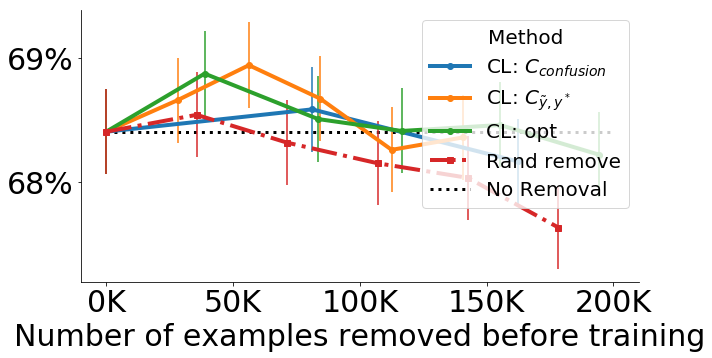

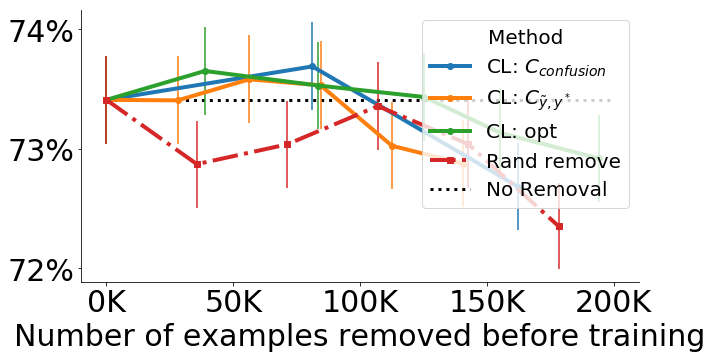

In [201]:
for model_name in ['resnet18', 'resnet50']:
    plot_data = {k:np.mean(v) for k,v in acc1s.items() if model_name in k}
    # Remove last three points of cl baseline
    if model_name == 'resnet50':
        for z in ['_60_argmax', '_80_argmax', '_100_argmax']:
            del plot_data[model_name + z]
    if model_name == 'resnet18':
#         del plot_data['resnet18_100_cj_only']
#         del plot_data['resnet18_60_cj_only']
        del plot_data['resnet18_60_argmax']
        del plot_data['resnet18_100_argmax']
    make_plot(
        plot_data,
        title="{}_imagenet_comparison_cl_methods".format(model_name),
        text_round=1, 
        savefig=True,
        plot_xlabel=True,
        legend_loc='upper right',
        legend_ncols=1,
        use_cl_opt=True,  # model_name=='resnet50',
        force_yaxis=True,
        plt_error_bars=True,
    )

[67, 102, 69]


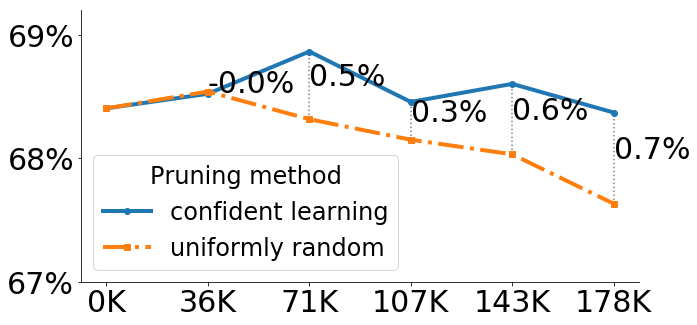

[72, 110, 74]


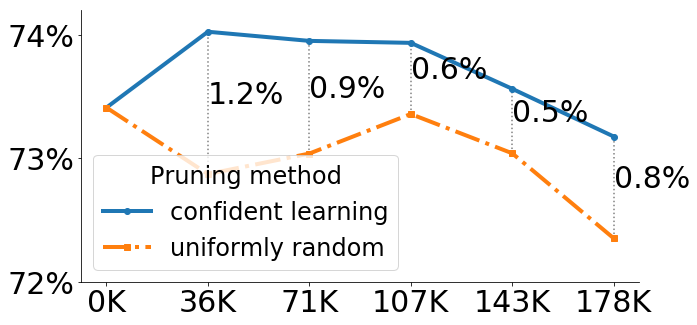

In [166]:
for model_name in ['resnet18', 'resnet50']:
    plot_data = {k:np.mean(v) for k,v in acc1s.items() if model_name in k}
    make_plot(plot_data, title = "{} ImageNet Validation Acc".format(model_name), text_round = 1, savefig = True, plot_xlabel = False)

In [64]:
for model_name in ['resnet18', 'resnet50']:
        scores = np.array(acc1s['{}_00'.format(model_name)]) + np.array(acc1s['{}_20random'.format(model_name)]) - np.array(acc1s['{}_20_both'.format(model_name)])
        for j in range(40, 101, 20):
            scores += np.array(acc1s['{}_00'.format(model_name)]) + np.array(acc1s['{}_{}random'.format(model_name, j)]) - np.array(acc1s['{}_{}_both'.format(model_name, j)])
        best_class_idx = np.argmin(scores)
        plot_data = {k:np.mean(v[best_class_idx]) for k,v in acc1s.items() if model_name in k}
#         title = r"{} Acc of {} noisiest classes".format(model_name, j)
        # Remove last three points of cl baseline
        if model_name == 'resnet50':
            for z in ['_60_argmax', '_80_argmax', '_100_argmax']:
                del plot_data[model_name + z]
        if model_name == 'resnet18':
            del plot_data['resnet18_80_cj_only']
#             del plot_data['resnet18_40_cj_only']
            del plot_data['resnet18_60_cj_only']
            del plot_data['resnet18_100_cj_only']
            del plot_data['resnet18_60_argmax']
            del plot_data['resnet18_100_argmax']
#         print(title)
        sys.stdout.flush()
        make_plot(
            plot_data,
            title=title,
            text_round=1, 
            savefig=False,
            plot_xlabel=False,
            legend_loc='upper right',
            legend_ncols=1,
            use_cl_opt=model_name=='resnet50',
        )
        plt.show()
#     make_plot(plot_data, title = title, savefig = False, plot_legend = False, plot_xlabel = False)

NameError: name 'title' is not defined

resnet18 Acc of 50 noisiest classes


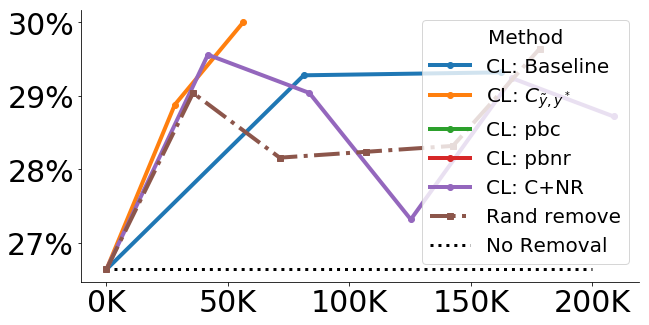

resnet18 Acc of 100 noisiest classes


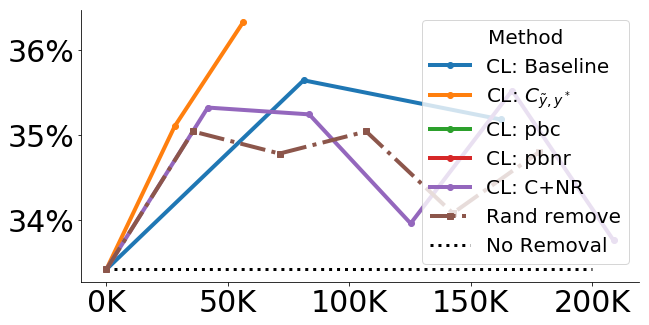

resnet18 Acc of 150 noisiest classes


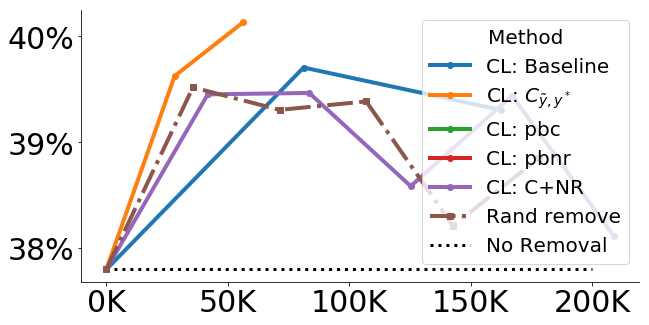

resnet18 Acc of 200 noisiest classes


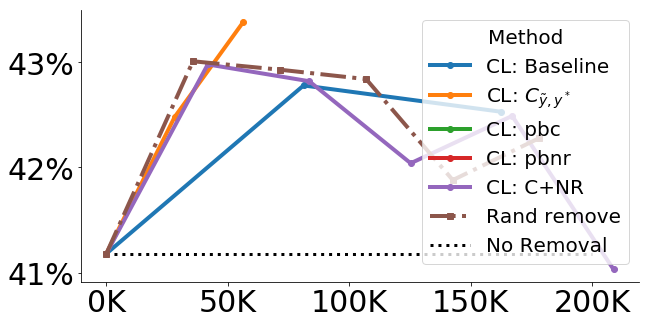

resnet50 Acc of 50 noisiest classes


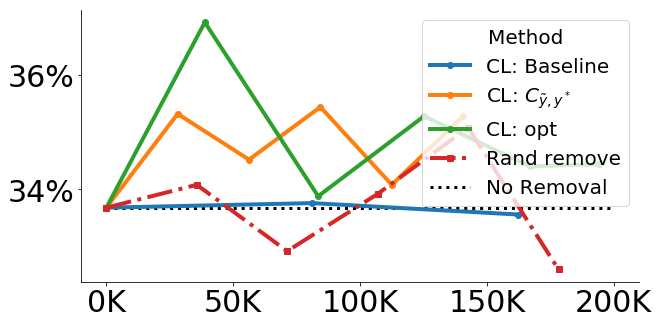

resnet50 Acc of 100 noisiest classes


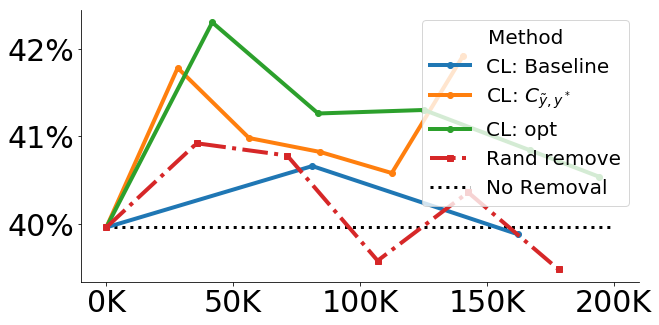

resnet50 Acc of 150 noisiest classes


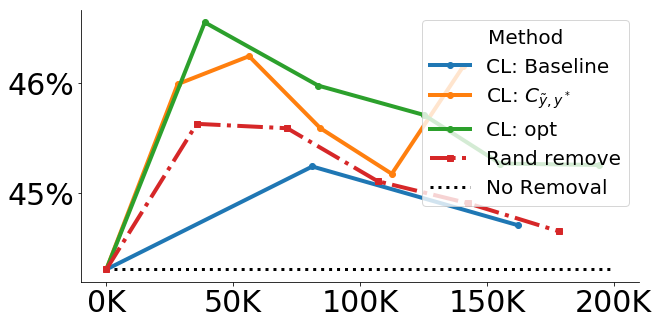

resnet50 Acc of 200 noisiest classes


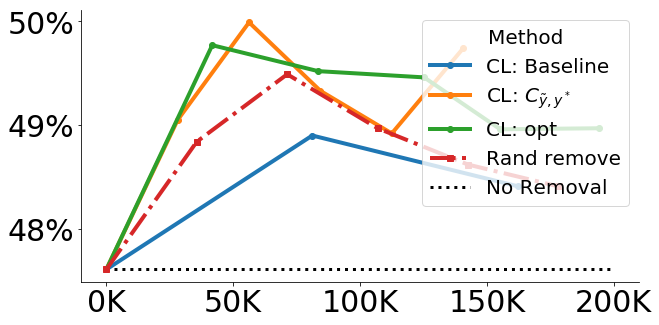

In [97]:
for model_name in ['resnet18', 'resnet50']:
    for j in list(range(50, 201, 50)):
        noisest_classes = np.argsort(acc1s['{}_00'.format(model_name)])
        plot_data = {k:np.mean([v[i] for i in noisest_classes[:j]]) for k,v in acc1s.items() if model_name in k}
        title = r"{} Acc of {} noisiest classes".format(model_name, j)
        # Remove last three points of cl baseline
        if model_name == 'resnet50':
            for z in ['_60_argmax', '_80_argmax', '_100_argmax']:
                del plot_data[model_name + z]
        if model_name == 'resnet18':
            del plot_data['resnet18_80_cj_only']
#             del plot_data['resnet18_40_cj_only']
            del plot_data['resnet18_60_cj_only']
            del plot_data['resnet18_100_cj_only']
            del plot_data['resnet18_60_argmax']
            del plot_data['resnet18_100_argmax']
        print(title)
        sys.stdout.flush()
        make_plot(
            plot_data,
            title=title,
            text_round=1, 
            savefig=False,
            plot_xlabel=False,
            legend_loc='upper right',
            legend_ncols=1,
            use_cl_opt=model_name=='resnet50',
        )
        plt.show()
#     make_plot(plot_data, title = title, savefig = False, plot_legend = False, plot_xlabel = False)

[37, 62, 44]


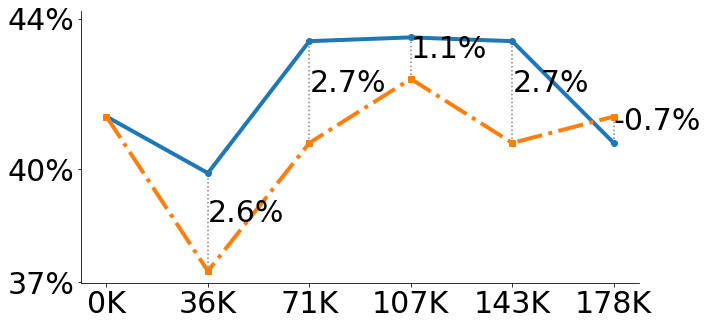

[43, 70, 49]


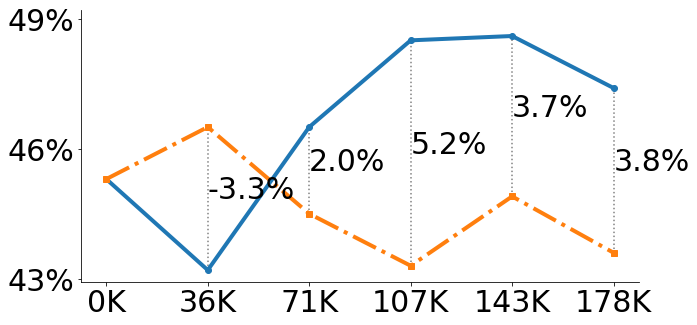

In [167]:
for model_name in ['resnet18', 'resnet50']:
    plot_data = {k:np.mean([v[i] for i in forty_noisiest_classes[:20]]) for k,v in acc1s.items() if model_name in k}
    title = r"{} Acc of 20 noisiest classes".format(model_name)
    make_plot(plot_data, title = title, savefig = True, plot_legend = False, plot_xlabel = False)

x_rand (0, 35658, 71317, 106976, 142635, 178294)
x_cl_both (0, 41765, 83531, 125296, 167062, 208828)
x_cl_cj_only (0, 28138, 84415, 140693)
x_cl_argmax (0, 81212, 162424)
x_rand (0, 35658, 71317, 106976, 142635, 178294)
x_cl_both (0, 41765, 83531, 125296, 167062, 208828)
x_cl_cj_only (0, 28138, 56277, 84415, 112554, 140693)
x_cl_argmax (0, 81212, 162424)


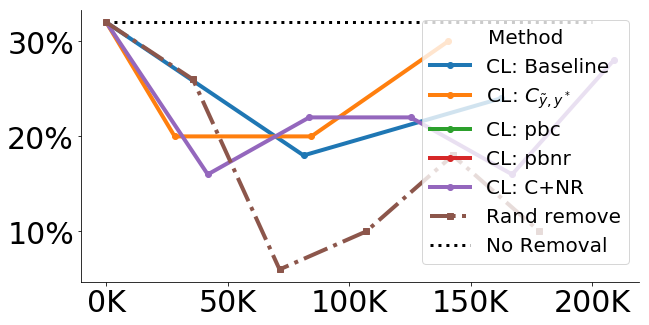

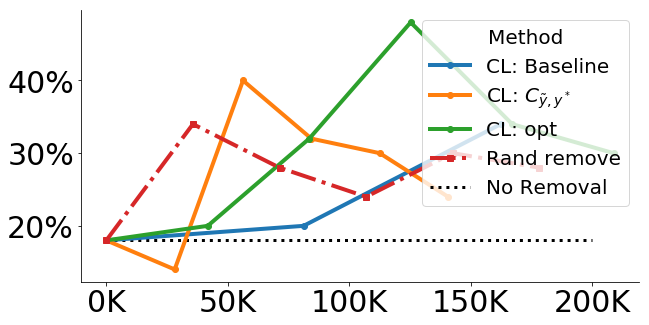

In [44]:
for model_name in ['resnet18', 'resnet50']:
    assert(nid2name[idx2nid[smallest_diag_idx]] == "English_foxhound")
    plot_data = {k:v[smallest_diag_idx] for k,v in acc1s.items() if model_name in k}
    # Remove last three points of cl baseline
    if model_name == 'resnet50':
        for z in ['_60_argmax', '_80_argmax', '_100_argmax']:
            del plot_data[model_name + z]
    if model_name == 'resnet18':
        del plot_data['resnet18_80_cj_only']
        del plot_data['resnet18_40_cj_only']
        del plot_data['resnet18_60_argmax']
        del plot_data['resnet18_100_argmax']
    title = '{} Acc of noisiest class: {}'.format(model_name, 'foxhound')
    make_plot(
        plot_data,
        title="{} ImageNet Validation Acc".format(model_name),
        text_round=1, 
        savefig=False,
        plot_xlabel=False,
        legend_loc='upper right',
        legend_ncols=1,
        use_cl_opt=model_name=='resnet50',
    )
      

[6, 37, 34]


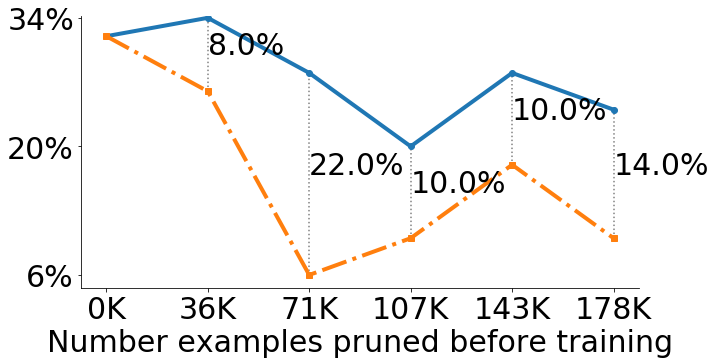

[18, 43, 34]


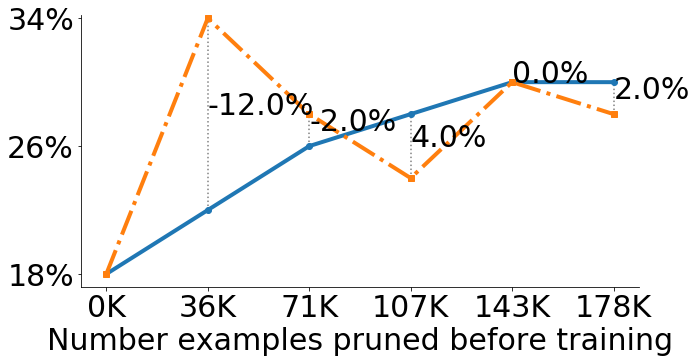

In [168]:
for model_name in ['resnet18', 'resnet50']:
    assert(nid2name[idx2nid[smallest_diag_idx]] == "English_foxhound")
    plot_data = {k:v[smallest_diag_idx] for k,v in acc1s.items() if model_name in k}
    title = '{} Acc of noisiest class: {}'.format(model_name, 'foxhound')
    make_plot(plot_data, title = title, savefig = True, plot_legend = False)

x_rand (0, 35658, 71317, 106976, 142635, 178294)
x_cl_both (0, 41765, 83531, 125296, 167062, 208828)
x_cl_cj_only (0, 28138, 112554)
x_cl_argmax (0, 81212, 162424)
x_rand (0, 35658, 71317, 106976, 142635, 178294)
x_cl_both (0, 41765, 83531, 125296, 167062, 208828)
x_cl_cj_only (0, 28138, 56277, 84415, 112554, 140693)
x_cl_argmax (0, 81212, 162424)


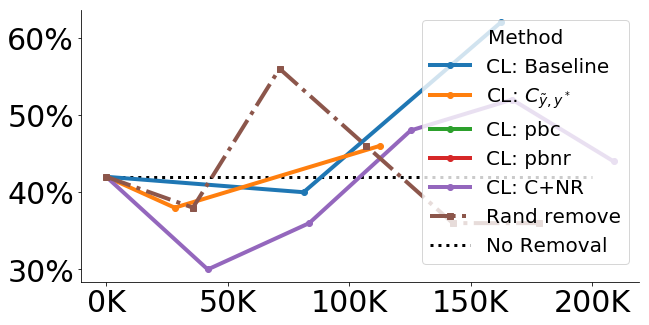

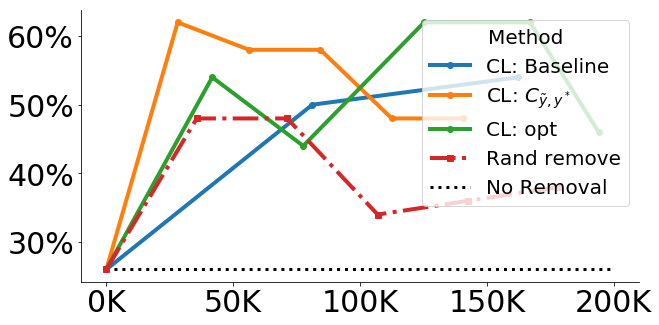

In [45]:
for model_name in ['resnet18', 'resnet50']:
    plot_data = {k:v[largest_non_diag_idx] for k,v in acc1s.items() if model_name in k}
    title = '{} Acc of a noisy class: {}'.format(model_name, nid2name[idx2nid[largest_non_diag_idx]])
    # Remove last three points of cl baseline
    if model_name == 'resnet50':
        for z in ['_60_argmax', '_80_argmax', '_100_argmax']:
            del plot_data[model_name + z]
    if model_name == 'resnet18':
        del plot_data['resnet18_100_cj_only']
        del plot_data['resnet18_60_cj_only']
        del plot_data['resnet18_40_cj_only']
        del plot_data['resnet18_60_argmax']
        del plot_data['resnet18_100_argmax']
    make_plot(
        plot_data,
        title="{} ImageNet Validation Acc".format(model_name),
        text_round=1, 
        savefig=False,
        plot_xlabel=False,
        legend_loc='upper right',
        legend_ncols=1,
        use_cl_opt=model_name=='resnet50',
    )

[46, 93, 70]


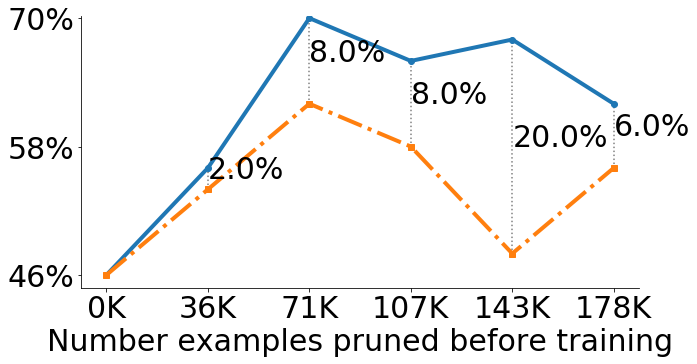

[50, 111, 86]


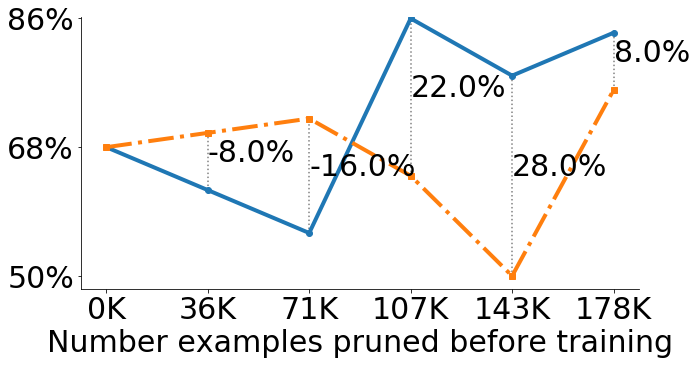

In [169]:
for model_name in ['resnet18', 'resnet50']:
    plot_data = {k:v[largest_non_diag_idx] for k,v in acc1s.items() if model_name in k}
    title = '{} Acc of a noisy class: {}'.format(model_name, nid2name[idx2nid[largest_non_diag_idx]])
    make_plot(plot_data, title = title, savefig = True, plot_legend = False)

In [ ]:
PyTorch 1.0  resnet152          77.62%  93.81%  3       3
PyTorch 1.0  resnet50           75.06%  92.48%  10      10
PyTorch 1.0  densenet121        74.07%  91.94%  12      12
PyTorch 1.0  resnet34           72.34%  90.84%  15      16
PyTorch 1.0  vgg16_bn           72.29%  91.01%  16      15
PyTorch 1.0  resnet18           68.37%  88.56%  28      26
PyTorch 1.0  alexnet            54.50%  77.64%  34      34

In [ ]:
Platform     Model              Acc@1   Acc@5   Rank@1  Rank@5
-----        -----              -----   ------  ------  -------
Keras 2.2.4  nasnetlarge        80.83%  95.27%  1       1
Keras 2.2.4  inceptionresnetv2  78.93%  94.45%  2       2
PyTorch 1.0  resnet152          77.62%  93.81%  3       3
Keras 2.2.4  xception           77.18%  93.49%  4       4
PyTorch 1.0  densenet161        76.92%  93.49%  5       5
PyTorch 1.0  resnet101          76.64%  93.30%  6       6
PyTorch 1.0  densenet201        76.41%  93.18%  7       7
Keras 2.2.4  inceptionv3        76.02%  92.90%  8       8
PyTorch 1.0  densenet169        75.59%  92.69%  9       9

Keras 2.2.4  densenet121        72.09%  90.70%  17      17
Keras 2.2.4  nasnetmobile       71.59%  90.19%  18      19
PyTorch 1.0  vgg19              71.19%  90.40%  19      18
PyTorch 1.0  vgg16              70.66%  89.93%  20      20
Keras 2.2.4  resnet50           70.35%  89.55%  21      22
PyTorch 1.0  vgg13_bn           70.12%  89.56%  22      21
Keras 2.2.4  mobilenetV2        69.98%  89.49%  23      23
PyTorch 1.0  vgg11_bn           69.36%  89.06%  24      24
PyTorch 1.0  inception_v3       69.25%  88.69%  25      25
Keras 2.2.4  mobilenet          69.02%  88.48%  26      27
PyTorch 1.0  vgg13              68.69%  88.65%  27      28
PyTorch 1.0  resnet18           68.37%  88.56%  28      26
PyTorch 1.0  vgg11              67.85%  88.11%  29      29
Keras 2.2.4  vgg19              65.58%  86.54%  30      30
Keras 2.2.4  vgg16              65.24%  86.20%  31      31
PyTorch 1.0  squeezenet1_0      56.49%  79.06%  32      33
PyTorch 1.0  squeezenet1_1      56.42%  79.21%  33      32
PyTorch 1.0  alexnet            54.50%  77.64%  34      34